In [1]:
from skbeam.core.accumulators.binned_statistic import RPhiBinnedStatistic
from skbeam.core.utils import radial_grid, angle_grid
from skbeam.core.image import construct_rphi_avg_image
from skbeam.core.reconstruction import EMCRecon2D

from pylab import *

%matplotlib notebook


In [2]:
def rotate(img,th,imgr,predef=None):
    '''Rotate a function using no interpolation. Should be faster.
        predef is a bunch of predefined variables. They are obtained by calling sub_rotate.
        Center of rotation is center of array.
    '''
    R = np.array([
        [np.cos(th), np.sin(th)],
        [-np.sin(th), np.cos(th)]
    ])

    imgr *= 0
    dims = img.shape
    #img = img.reshape(dims[0]*dims[1])
    #imgr = imgr.reshape(dims[0]*dims[1])
    if(predef is None):
        r,x,y,cen = sub_rotate(dims)
    else:
        r,x,y,cen = predef

    rp = np.dot((r-cen),R) + cen#broadcast cen array
    rp = rp.reshape((dims[0]*dims[1],2))
    xbins = np.linspace(x[0]-.5,x[-1]+.5,dims[0]+1)
    ybins = np.linspace(y[0]-.5,y[-1]+.5,dims[1]+1)
    xd = np.searchsorted(xbins,rp[:,0],side="right")-1
    yd = np.searchsorted(ybins,rp[:,1],side="right")-1
    w = np.where((xd >= 0) & (xd < dims[0]) & (yd >= 0) & (yd < dims[1]))
    xd = xd[w]
    yd = yd[w]
    #rd = xd + yd*dims[0] 
    #rr = r[w,0] + r[w,1]*dims[0]
    imgr[r[w,0],r[w,1]] = img[xd,yd]

def sub_rotate(dims):
    '''Subroutine to rotate. If you call rotate multiple times, use the
    parameters returned here as the predef parameter to rotate.  It avoids the
    re-creation of many unnecessary routines.'''
    x = np.arange(dims[0])
    y = np.arange(dims[1])
    X,Y = np.meshgrid(x,y)
    r = np.dstack((X,Y))
    r = r.reshape((dims[0]*dims[1],2))
    cen = np.array([dims[0]/2.,dims[1]/2.]).reshape((1,1,2))
    return r,x,y,cen

<IPython.core.display.Javascript object>


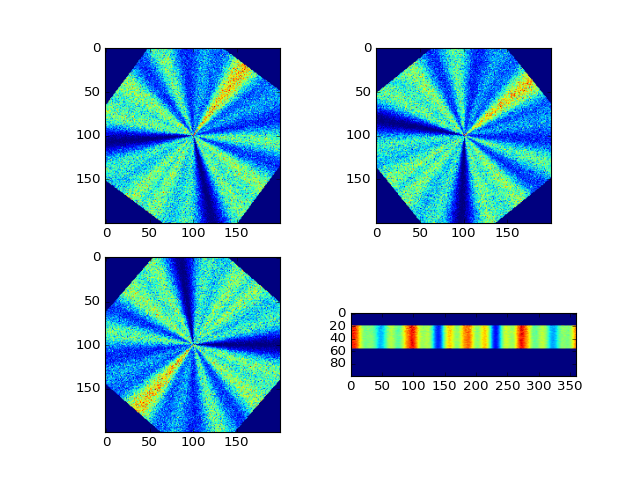

<IPython.core.display.Javascript object>


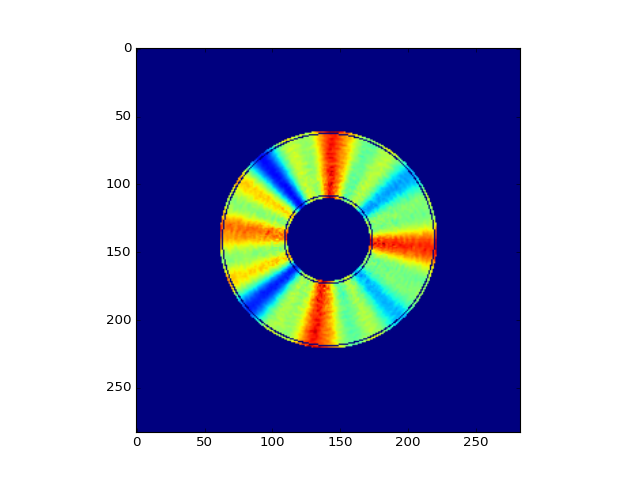

EMC: Step 0 of 10


/home/julienl/research/projects/scikit-beam/skbeam/core/reconstruction.py:235: RuntimeWarning: invalid value encountered in true_divide
  axis=2)/np.sum(R_jk, axis=1)[np.newaxis, :]


EMC: Step 1 of 10
EMC: Step 2 of 10
EMC: Step 3 of 10
EMC: Step 4 of 10
EMC: Step 5 of 10
EMC: Step 6 of 10
EMC: Step 7 of 10
EMC: Step 8 of 10
EMC: Step 9 of 10


In [3]:
thresh = 100 # prob threshold

# image dimensions
musam = 10.
mubg = 0.
Nx, Ny = 200, 200
img = np.zeros((Ny, Nx))
origin = Ny/2., Nx/2.
rs = radial_grid(origin, img.shape)
phis = angle_grid(origin, img.shape)
mask = np.ones_like(img)
mask[(rs < 30)] = 0
mask[(rs > 80)] = 0

img = (np.cos(phis*3.45)**2 + np.cos(phis*6.21)**2 + np.cos(phis*2)**2)*musam
Nimgs = 20

imgs = np.zeros((Nimgs, img.shape[0], img.shape[1]))

figure(0);clf();
imshow(mask*img);


imgr = img*0
# make 20 images of random rotations
for i in range(Nimgs):
    phir = np.random.random()*2*np.pi
    rotate(img, phir, imgr)
    imgs[i] = np.random.poisson(imgr)




figure(1);clf();
imshow(imgs[0]*mask)

noqs = 100
nophis = 360
emcrecon = EMCRecon2D(imgs[0].shape, mask=mask, origin=origin, bins=(noqs, nophis),
                      Niter=10, Nrot=100)
#rvals, phivals, W_model, W_model_mask, R_jk = emcrecon2D(imgs, mask=mask,
                                                         #origin=origin, bins =
                                                         #(noqs, nophis),
                                                         #Niter=10, Nrot = 100,
                                                         #PF=True,
                                                         #return_rotations=True)
rvals, phivals, W_model, W_model_mask, R_jk = emcrecon(imgs, return_rotations=True)
phivals = phivals+np.pi
#rvals = np.tile(rvals[:,np.newaxis], (1,nophis))
#phivals = np.tile(phivals[np.newaxis,:], (noqs,1))
#rvals = rvals[:,0]
#phivals = phivals[0]


rphiimg = construct_rphi_avg_image(rvals, phivals, W_model, mask=W_model_mask)

figure(0);clf();
subplot(2,2,1)
imshow(imgs[0])
subplot(2,2,2)
imshow(imgs[1])
subplot(2,2,3)
imshow(imgs[3])
subplot(2,2,4)
imshow(W_model)
#lbook.sfig("0838-EMrecon2D-ex")


figure(1);clf();imshow(rphiimg)
